In [49]:
import cv2
import re
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from paddleocr import PaddleOCR
from copy import copy, deepcopy

# constants for OCR management
OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=False)
SYMBOLS = "+:-xX—_"
REPLACEMENT_PAIRS = [
    ('6', '9'),
    ('2', '5')
]

SKIP_VERIFICATION = True
FILENAME = "kenken.png"

# for quietly stopping jupyter cell
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# stores operation types for readability
class Ops:
    SUBTRACTION = "-"
    MULTIPLICATION = "*"
    DIVISION = "/"
    ADDITION = "+"
    CONSTANT = "_"

class Point:
	def __init__(self, x, y):
		self.x = x
		self.y = y
	def __repr__(self):
		return f"({self.x}, {self.y})"
	def __str__(self):
		return self.__repr__()
	def get_iter(self, size):
		return int(size*self.y + self.x)

# shows an image on ipynb
def imshow(img):
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# gets the amount of blur to do depending on the game size
""" Fine tune these values for different quality screenshots. """
def getblur(game_size) -> tuple[int, int]:
    match game_size:
        case 3|4|5:
            return (41, 41)
        case 6|7|8:
            return (37, 37)
        case 9:
            return (33, 33)

<hr>

<i>Crop the image by its largest contour.</i> 

After this step, the image should have an even border.

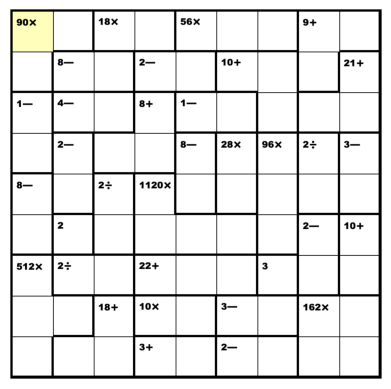

In [50]:
# Read the input image and perform cropping
og_img = cv2.imread(FILENAME)
gray = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,150,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# assumes the square is the most significant contour on the page
outer_border = sorted(contours, key=cv2.contourArea)[-2]   
x, y, w, h = cv2.boundingRect(outer_border)
img = og_img[y:y+h, x:x+w]

# saves variables for later use
cropped_dims = {
    "x": x,
    "y": y,
    "w": w,
    "h": h
}

imshow(img)

<hr>

<i>Determine the game size.</i>

If the determined game size is not accurate, manually set it.

In [51]:
# calculate game size from the contours
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,150,255,0)
new_contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
newimg = cv2.drawContours(img.copy(), new_contours, -1, (0,255,0), 3)

# sorts by largest, then finds the first one that isnt the size of the entire game, this is one box
for contour in sorted(new_contours, key=cv2.contourArea, reverse=True):
    x, y, w, h = cv2.boundingRect(contour)
    ratio = len(img) // min(w, h)
    if ratio == 1:
        continue
    else:
        GAME_SIZE = ratio
        break

print(f"The game size is {GAME_SIZE}.")

# GAME_SIZE =    # MNAUALLY SET IT HERE

The game size is 9.


<hr>

<i>Find all the blocks in the image.</i>

After this step, the outputted image should have green outlines wherever the major blocks are.

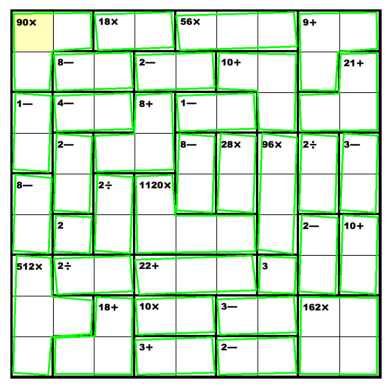

In [52]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, getblur(GAME_SIZE), 0)
ret, thresh = cv2.threshold(blur,150,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# get heavily dark contours provided it is not text
filtered = []; shapes = []
for contour in contours:
    epsilon = 0.02*cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) >= 4:
        x, y, w, h = cv2.boundingRect(contour)
        if min(w, h) > len(img) / 10:       # assures that no numbered contours are interpreted
            filtered.append(contour)
            shapes.append(approx)

# draw the contour on the input image
newimg = cv2.drawContours(img.copy(), shapes, -1, (0,255,0), 3)

# display the image with drawn contours and approximate contours
imshow(newimg)

<hr>

<i>Determine the operations within each square, preparing it for solving.</i>

If something is going wrong, check the printed result and assure it is consistent with the image.

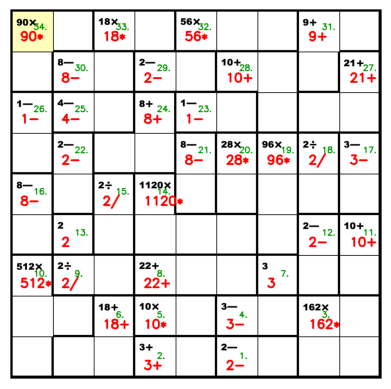

In [53]:
# stores box size as a variable
BOX_SIZE = len(img) / GAME_SIZE 

# processing for OCR-read text
def process(text: str):
    text = text.replace(' ', '')    # remove spaces everywhere
    text = text.lower()             # standardize style
    text = text.strip()             # remove any whitespace (like \n, \t)

    if [char for char in text if char not in SYMBOLS] == []:
        return None

    # undo 180-degree interpreted rotation by the OCR
    if text[0] in SYMBOLS:
        text = [*reversed(text)]
        for replacement in REPLACEMENT_PAIRS:
            for i, char in enumerate(text):
                if char in replacement:
                    text[i] = r1 if char != (r1:=(replacement[1])) else replacement[0]
        return "".join(text)
    
    return text

# prints an operation onto an image of a board, depending on its location
def show_interpretation(img, operation):
    dispimg = img.copy()
    point = operation["text_point"]

    # write the number
    dispimg = cv2.putText(
        img=dispimg,
        text=str(operation["result"]) + operation["operand"].replace("_", ''),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        thickness=3,
        fontScale=BOX_SIZE/100,
        org=(
            int((point.x + 1/4) * BOX_SIZE),
            int((point.y + 1/1.3) * BOX_SIZE)
        ),
        color=(0, 0, 255)
    )
    # write the id
    dispimg = cv2.putText(
        img=dispimg,
        text=str(operation["id"]) + ".",
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        thickness=2,
        fontScale=BOX_SIZE/150,
        org=(
            int((point.x + 1/1.75) * BOX_SIZE),
            int((point.y + 1/2) * BOX_SIZE)
        ),
        color=(0, 150, 0)
    )

    return dispimg

# made specifically for my purposes where the polygon is all right angles and the points are right in the middle
def is_inside(polygon, point):
    intersection_count = 0
    for p1, p2 in zip(polygon, polygon[1:]+[polygon[0]]):

        # skip horizontal lines
        if p1.y == p2.y:
            continue

        # assumes that p1.x and p2.x are equal to each other as its either horizontal or vertical
        if point.x < p1.x and (p1.y < point.y < p2.y or p2.y < point.y < p1.y):
            intersection_count += 1
    
    return intersection_count % 2 == 1   # odd number of intersections means its within

def number_contour_count(num: int) -> int:
    """ Returns the number of contours in the number. """
    match num:
        case 1 | 2 | 3 | 5 | 7:
            return 1
        case 4 | 6 | 9:
            return 2
        case 8:
            return 3

# determine which squares are inside each group
relations = []
for approx in shapes:

    # turns pixel counts into box counts into point lists
    approx = list(map(lambda arr: list(map(lambda x: round(x/BOX_SIZE), arr[0])), approx))
    points = list(map(lambda x: Point(*x), approx))

    # determine a rectangle around the approximation
    x, y, w, h = cv2.boundingRect(np.array(approx))
    rel = []

    # loop through points that are in the exact middle to avoid weird shape determinations
    for xx in np.arange(start=x+0.5, stop=x+w-0.5, step=1):     
        for yy in np.arange(start=y+0.5, stop=y+h-0.5, step=1):
            if is_inside(points, Point(xx, yy)):
                rel.append(Point(xx-0.5, yy-0.5))
    relations.append(rel)
    
# standardize all the colors
grayed = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
newimg = cv2.convertScaleAbs(grayed, alpha=2)
# newimg = img.copy()

# starter values
operations = []
dispimg = img.copy()
id = 1

for i in range(len(relations)):
    rel = relations[i]
    operation = {
        "id": id,
        "result": None,
        "operand": None,
        "squares": [],
        "text_point": None
    }

    # go through each square in the relation
    for point in rel:      

        # gets the box of the square
        y_lower, x_lower = max(int((point.y + 0.05)*BOX_SIZE), 0), max(int((point.x + 0.05)*BOX_SIZE), 0)
        y_upper, x_upper = int(y_lower+BOX_SIZE * 0.9), int(x_lower+BOX_SIZE * 0.9)
        cropped_img = newimg[y_lower:y_upper, x_lower:x_upper]
        
        # checks if text could be read
        if (text:=OCR.ocr(cropped_img, cls=True)) != [[]]:
            text = process(text[0][0][1][0])     # get prediction and process it

            # debugging purposes 
            """print(text)
            imshow(cropped_img)
            continue"""

            if text == None:    # skip if invalid text
                continue
            
            """ By this step, <text> should be a string like this: "17+", "14x", "3:", etc. """
            if "+" in text:
                operation["operand"] = Ops.ADDITION
                operation["result"] = int(text.replace("+", ""))
            elif ":" in text:
                operation["operand"] = Ops.DIVISION
                operation["result"] = int(text.replace(":", ""))
            elif "x" in text:
                operation["operand"] = Ops.MULTIPLICATION
                operation["result"] = int(text.replace("x", ""))
            elif any([s in text for s in ["-", "—", "_", "."]]):
                operation["operand"] = Ops.SUBTRACTION
                operation["result"] = int(re.sub(r"[\_\-\—\.]+", "", text))
            
            # likely fully empty - nothing to check inside
            else:   
                operation["result"] = int(text)
                text = cropped_img
                match len(rel):
                    case 2: 
                        # cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
                        # cropped_img = cv2.GaussianBlur(cropped_img, (3, 3), 0)
                        contours, hierarchy = cv2.findContours(cropped_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
                        contour_length = len(contours)

                        # determine how many contours there are, differentiate between div and sub
                        if contour_length - number_contour_count(operation["result"]) > 2:
                            operation["operand"] = Ops.DIVISION
                        else:
                            operation["operand"] = Ops.SUBTRACTION
                    case 1:
                        operation["operand"] = Ops.CONSTANT
                    case _:
                        raise Exception("Invalid pattern detected.")
                    
            # sotres values within the operation
            operation["squares"] = copy(rel)
            operation["text_point"] = point

            # adds interpretation to display image
            dispimg = show_interpretation(dispimg, operation)
            id += 1
            break
        
    if operation["operand"] != None:    # makes sure it's not empty
        operations.append(operation) 
        
imshow(dispimg)

<hr>

<i>Review the interpreted relationships.</i>

In [54]:
if SKIP_VERIFICATION:
    if sum([len(operation["squares"]) for operation in operations]) != GAME_SIZE**2:
        print("Missing relationships detected. Could not skip verification.")
    else:
        print("Verification was skipped.")
        raise StopExecution

print("Review the interpreted relationships by looking at the image.")

imshow(dispimg)

class Modification:
    CHANGE  = 1
    ADD     = 2
    EXIT    = 3

logs = []

option = -1
while option != Modification.EXIT:

    # determiens what to do
    dispimg = img.copy()
    option = int(input("Enter 1 to change a relation, 2 to add one, or 3 if everything is good: "))
    
    if option == Modification.CHANGE:

        # obtain updated inforamtion
        target_id = int(input("Enter the ID of the operation you want to edit: "))
        result = int(input("Enter the result of the operation: "))
        operand = input("Enter the operand ('_' for constant, '-' for subtraction, '+' for addition, '/' for division, and '*' for multiplication): ")

        # make sure its the right one and perform change
        operation = operations[target_id-1]
        assert target_id == operation["id"], "Error finding operation."

        # stores old values and gets new ones
        old_operand, old_result = operation["operand"], operation["result"]
        operation["operand"] = operand
        operation["result"] = result

        logs.append(f"Changed operation {target_id} from {old_result}{old_operand} to {result}{operand}.")

    elif option == Modification.ADD:
        points = []

        # get information
        result = int(input("Enter the result of the operation: "))
        operand = input("Enter the operand ('_' for constant, '-' for subtraction, '+' for addition, '/' for division, and '*' for multiplication): ")
        new_point = -1

        # gets all the points to add
        while True:
            new_point = input("Enter the coordinate of a box in the relationship in the format \"x, y\", where the top left point is (0, 0), and the bottom right point is (<size>, <size>), or press enter if there are no points remaining: ")
            if new_point != '':
                points.append(Point(*map(int, re.split("[, ]+", new_point))))
            else:
                break
        
        # saves the new operation
        operations.append({
            "id": id,
            "operand": operand,
            "result": result,
            "squares": points,
            "text_point": points[0]
        })

        id += 1

        logs.append(f"Added relation with points {', '.join(map(str, points))} resulting in {result}{operand}.")

    for operation in operations:
        dispimg = show_interpretation(dispimg, operation)

    clear_output(wait=True)
    print("Updated graph: ")
    imshow(dispimg)
    
# shows a log of the changes made
print("\n".join(logs))

Verification was skipped.


<hr>

<i>Solve the puzzle.</i>

In [55]:
# gets raised if the board is solved
class SolveError(Exception):
    def __init__(self, message):
        self.message = message

# check for unique values in columns or rows
def illegal_col(board, col_num):
    return len(a:=([v for i in range(GAME_SIZE) if (v:=board[i][col_num]) != 0])) != len(set(a))
def illegal_row(board, row_num):
    return len((a:=[v for v in board[row_num] if v != 0])) != len(set(a))

# modify a 2d array given a number representing an iteration on that board
def mod_board(board, num, val):
    board[num//GAME_SIZE][num%GAME_SIZE] = val

# gets the value on a board given a number representing an iteration
def get_board(board, num):
    return board[num//GAME_SIZE][num%GAME_SIZE]

# determine the possible values for each point
def get_possible_values(operation):
    result = operation["result"]
    match operation["operand"]:

        # single item in set
        case Ops.CONSTANT:
            return {result}
        
        # cannot have values that do not have a difference within the range
        # difference of 7 forces {8, 1, 9, 2} in game size 9
        case Ops.SUBTRACTION:
            output = list()
            for i in range(result+1, GAME_SIZE+1):
                output.extend([i, i-result])
            return set(output)
        
        # can only have numbers both in the range and have products in the range
        # quotient of 2 forces {1, 2, 3, 4, 6, 8} in game size 9
        case Ops.DIVISION:
            output = list()
            for i in range(1, GAME_SIZE // result + 1):
                if i*result <= GAME_SIZE:
                    output.extend([i, i*result])
            return set(output)
        
        # only have factors within the range
        case Ops.MULTIPLICATION:
            return {i for i in range(1, GAME_SIZE+1) if result % i == 0}
        
        # formulates bounds for both high sums and low sums
        case Ops.ADDITION:
            """
            The lower bound is the minimum value you can have while the rest of the summation provides a good result.
            Not extremely optimized, but with a game size of 6, a sum of 15 with a number of squares 3 provides a minimum value of 3, as 6+6+3 = 15.

            The maximum value is the max you can have, while all other squares are one, that still allows for the sum to be limited.
            When you have a sum of 8 and a number of values of 4, you can have at most 5, as 5+1+1+1 is 8.
            """
            length = len(operation["squares"])
            return {*range(max(1, result - GAME_SIZE*(length-1)), min(GAME_SIZE, result-length+1)+1)}
        
def check_possible(board, iter, value):
    global rels
    try:

        # initially modifies the assignment
        mod_board(board, iter, value)

        # checks rows and columns for legality
        if illegal_col(board, iter%GAME_SIZE):
            return False
        elif illegal_row(board, iter//GAME_SIZE):
            return False
        
        # options values to use in the remaining analysis
        operation = get_board(rels, iter)
        result = operation["result"]
        iters = [point.get_iter(GAME_SIZE) for point in operation["squares"]]
        values = [get_board(board, iter) for iter in iters]

        # case-sensitive analysis on the type of operation being done
        match operation["operand"]:

            # length of values will be 2
            case Ops.SUBTRACTION:
                v1, v2 = values

                # if its blank its not decided what will work yet
                if v1 == 0 or v2 == 0:  
                    return True

                # otherwise, make sure its a valid difference 
                return abs(v2 - v1) == result
            
            case Ops.ADDITION:
                zero_count = values.count(0)

                # not possible if the sum is already greater or equal to, given all zeros are replaced with ones
                if zero_count > 0:
                    return sum(values) <= result - zero_count
                
                # otherwise find normal sum
                return sum(values) == result
            
            case Ops.DIVISION:
                v1, v2 = values

                # if either are zero its not decided yet
                if v1 == 0 or v2 == 0:
                    return True
                
                # otherwise the greater over the smaller must be the result
                return round(max(v1, v2) / min(v1, v2), 2) == result
            case Ops.MULTIPLICATION:

                # make sure the product is not already greater than the result
                if any([val == 0 for val in values]):
                    return np.prod([val for val in values if val != 0]) <= result    
                
                # otherwise check that the product is equal to the result
                return np.prod(values) == result
   
    # reset the value after checks are done
    finally:
        mod_board(board, iter, 0)

# make sure the operations are valid
assert (sum([len(operation["squares"]) for operation in operations])) == GAME_SIZE**2, "Missing relationships. Please validate them."

# make blank arrays for everything
board = [[0 for _ in range(GAME_SIZE)] for _ in range(GAME_SIZE)]
possible_values = deepcopy(board)
rels = deepcopy(board)

solved = False

# fill arrays
for op in operations:
    for point in op["squares"]:

        # assign possible values and relations to each point
        iter = point.get_iter(GAME_SIZE)
        mod_board(possible_values, iter, get_possible_values(op))
        mod_board(rels, iter, op)

        # also adjust board if the point is constant
        if op["operand"] == Ops.CONSTANT:
            mod_board(board, iter, op["result"])

# recursive backtracking algorithm for solving
def solve(board, iter):
    
    # if the iter goes past the final square it is done
    if iter >= GAME_SIZE**2:
        raise SolveError("Catch me! I'm done!")
        
    # skip if its a constant value
    if get_board(board, iter) != 0:
        solve(board, iter+1); return
    
    # go through each value in the possible values, check if its possible, and if so, solve 1 level deeper
    possible = get_board(possible_values, iter)
    for value in list(possible):
        if check_possible(board, iter, value):
            mod_board(board, iter, value)
            solve(board, iter+1)

    # reset if unsuccessful
    mod_board(board, iter, 0)       

try: 

    solve(board, 0)

    # if made it through this point its not solved
    print("Couldn't solve board.")

# raised when the board is printed successfully
except SolveError:
    print(board)
    solved = True
    
# something went wrong
except:
    print("Board couldn't be solved.")

[[5, 6, 2, 9, 8, 1, 7, 3, 4], [3, 1, 9, 8, 6, 5, 4, 2, 7], [7, 9, 5, 4, 3, 2, 1, 6, 8], [6, 5, 1, 3, 9, 7, 8, 4, 2], [9, 3, 6, 7, 1, 4, 2, 8, 5], [1, 2, 3, 5, 4, 8, 6, 7, 9], [2, 4, 8, 6, 7, 9, 3, 5, 1], [4, 8, 7, 2, 5, 6, 9, 1, 3], [8, 7, 4, 1, 2, 3, 5, 9, 6]]


<hr>

<i>Write the board onto the original image.</i>

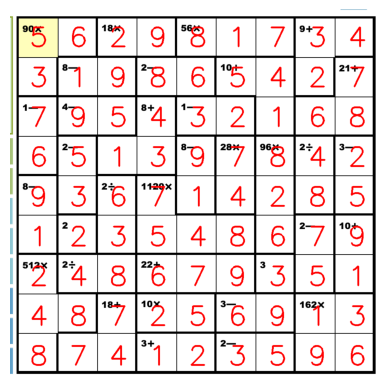

In [56]:
# exit if not solved
if not solved:
    print("Board was not solved.")
    raise StopExecution

# controls distance from the corner of a box
y_buf = BOX_SIZE / 1.3
x_buf = BOX_SIZE / 3

# controls image offset based on cropping
x_offset = cropped_dims["x"]
y_offset = cropped_dims["y"]

# copies original image for writing
newimg = og_img.copy()

# fills in each number in the board
for y in range(GAME_SIZE):
    for x in range(GAME_SIZE):
        num = board[y][x]
        x_pos = int(x * BOX_SIZE + x_buf + x_offset)
        y_pos = int(y * BOX_SIZE + y_buf + y_offset)
        newimg = cv2.putText(newimg, str(num), org=(x_pos, y_pos), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2.5, color=(0, 0, 255), thickness=4)

imshow(newimg)